In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const

from commpy.modulation import QAMModem

from optic.core import parameters
from optic.tx import simpleWDMTx
from optic.models import phaseNoise, hybrid_2x4_90deg
from optic.dsp import pulseShape, firFilter
from optic.metrics import signal_power

import logging as logg
logg.getLogger().setLevel(logg.INFO)
logg.basicConfig(format='%(message)s')

In [2]:
import importlib.util

# Import OFE.py (Optical Front-End)
spec = importlib.util.spec_from_file_location("OFE", "../../utils/OFE.py")
OFE = importlib.util.module_from_spec(spec)
spec.loader.exec_module(OFE)

# Import mitigationSBBI.py
spec_2 = importlib.util.spec_from_file_location("mitigationSSBI", "../../utils/mitigationSSBI.py")
SSBI = importlib.util.module_from_spec(spec_2)
spec_2.loader.exec_module(SSBI)

In [3]:
# Parâmetros - Transmissor
paramTx = parameters()

paramTx.M   =  256         # Ordem do formato de modulação
paramTx.constType = 'qam'   # Formato de modulação ('qam' ou 'psk')

paramTx.Rs  = 100e9         # Taxa de sinalização [baud]
paramTx.SpS = 4             # Número de amostras por símbolo
Fs = paramTx.Rs*paramTx.SpS # Taxa de amostragem [Hz]

paramTx.Nbits = 300000  # Número total de bits por polarização

paramTx.pulse    = 'rrc'   # Tipo do filtro formatador de pulso
paramTx.Ntaps    = 1024    # Número de coeficientes do filtro
paramTx.alphaRRC = 0.01    # Rolloff do pulso RRC

paramTx.Pch_dBm  = 0       # Potência média por canal WDM [dBm]
paramTx.Nch      = 1       # Número de canais WDM
paramTx.freqSpac = 40.0e9  # Espaçamento WDM

paramTx.Fc     = 193.1e12  # Frequência central de operação
paramTx.Nmodes = 1         # Número de modos de polarização

Tx = ['Parâmetros do Transmissor:',
      '- Formato de Modulação: {}-{}' .format(paramTx.M, paramTx.constType.upper()),
      '- Taxa de Sinalização: {} Gbaud' .format(paramTx.Rs*1e-9),
      '- Taxa de Amostragem: {} GHz' .format(Fs*1e-9),
      '- Potência Média Enviada: {} dBm' .format(paramTx.Pch_dBm),
      '- Frequência de Operação: {} THz' .format(paramTx.Fc*1e-12),
      '- Número de polarizações do sinal: {}\n' .format(paramTx.Nmodes)]
for i in Tx:
    print(i)

# generate WDM signal
sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

Parâmetros do Transmissor:
- Formato de Modulação: 256-QAM
- Taxa de Sinalização: 100.0 Gbaud
- Taxa de Amostragem: 400.0 GHz
- Potência Média Enviada: 0 dBm
- Frequência de Operação: 193.1 THz
- Número de polarizações do sinal: 1



  0%|          | 0/1 [00:00<?, ?it/s]

channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm


Text(0.5, 1.0, 'optical WDM spectrum')

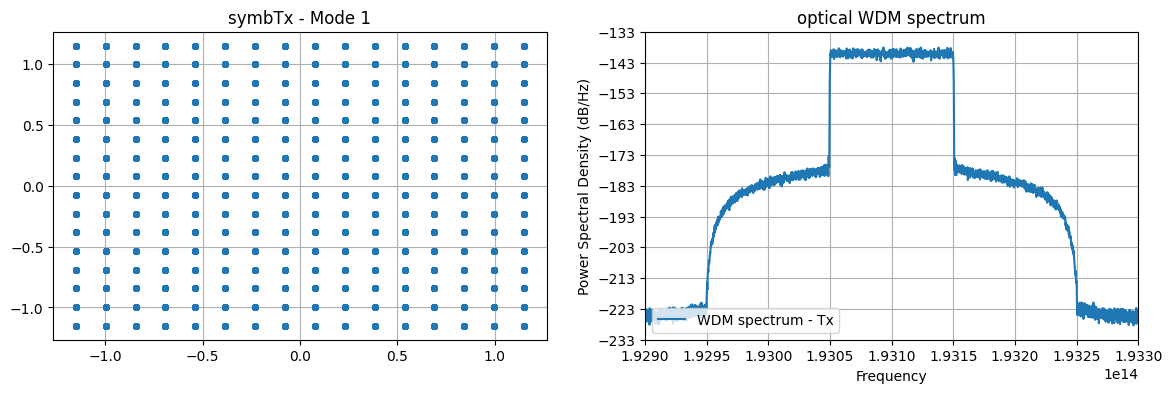

In [4]:
# plot psd and constellations (pós-geração)
fig, axs = plt.subplots(1, 2, figsize=(14,4))

axs[0].plot(np.squeeze(symbTx_).real, np.squeeze(symbTx_).imag,'.', markersize=7)
axs[0].set_title('symbTx - Mode 1')
axs[0].grid('True')

axs[1].psd(sigWDM_Tx[:,0], Fs=Fs, Fc=paramTx.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
axs[1].set_xlim(paramTx.Fc-Fs/2,paramTx.Fc+Fs/2)
axs[1].legend(loc='lower left')
axs[1].set_title('optical WDM spectrum')

In [5]:
# Canal Óptico
print('back-to-back connection.')
sigWDM = sigWDM_Tx

back-to-back connection.


In [6]:
# Parâmetros - Receptor
mod = QAMModem(m=paramTx.M)

chIndex  = 0     # Posição do canal WDM a ser demodulado
Fc = paramTx.Fc
Ts = 1/Fs

freqGrid = paramTx.freqGrid
print(f'Demodulating channel #{chIndex} \n',
      f'- fc: {((Fc + freqGrid[chIndex])/1e12):.4f} THz\n',
      f'- λ: {(const.c/(Fc + freqGrid[chIndex])/1e-9):.4f} nm\n')

symbTx = symbTx_[:,:,chIndex]

Demodulating channel #0 
 - fc: 193.1000 THz
 - λ: 1552.5244 nm



In [7]:
# Parâmetros - Receptor - Oscilador Local
π       = np.pi
FO      = 0*64e6                # Offset de frequência
Δf_lo   = freqGrid[chIndex]+FO  # Deslocamento de frequência do canal a ser demodulado
lw      = 0*100e3               # LineWidth
Plo_dBm = 15                    # Potência [dBm]
Plo     = 10**(Plo_dBm/10)*1e-3 # Potência [W]
ϕ_lo    = 0                     # Fase inicial [rad]    

print(f'Local oscillator\n',
      f'- Power: {Plo_dBm:.2f} dBm\n',
      f'- LineWidth: {(lw/1e3):.2f} kHz\n',
      f'- Frequency offset: {(FO/1e6):.2f} MHz')

# Geração do sinal LO
t       = np.arange(0, len(sigWDM))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigWDM), Ts)
sigLO   = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

Local oscillator
 - Power: 15.00 dBm
 - LineWidth: 0.00 kHz
 - Frequency offset: 0.00 MHz


In [8]:
# Receptor óptico single-ended
sigWDM = sigWDM.reshape(len(sigWDM),)
R1, R2 = OFE.SEReceiver( sigWDM, sigLO)

# Sinal recuperado após os PDs
sigPD = R1 + 1j*R2
sigPD = sigPD - np.mean(sigPD)

In [9]:
# Algoritmo de cancelamento iterativo da SSBI
sigIC = SSBI.IC(R1, R2, sigWDM, sigLO, N=10, clipping=False)

In [10]:
# filtro casado
pulse = pulseShape('rrc', paramTx.SpS, paramTx.Ntaps, paramTx.alphaRRC)
pulse = pulse/max(abs(pulse))

sigWDM = firFilter(pulse, sigWDM)
sigPD = firFilter(pulse,sigPD)
sigIC = firFilter(pulse, sigIC)

sigWDM = sigWDM/np.sqrt(signal_power(sigWDM))
sigPD = sigPD/np.sqrt(signal_power(sigPD))
sigIC = sigIC/np.sqrt(signal_power(sigIC))

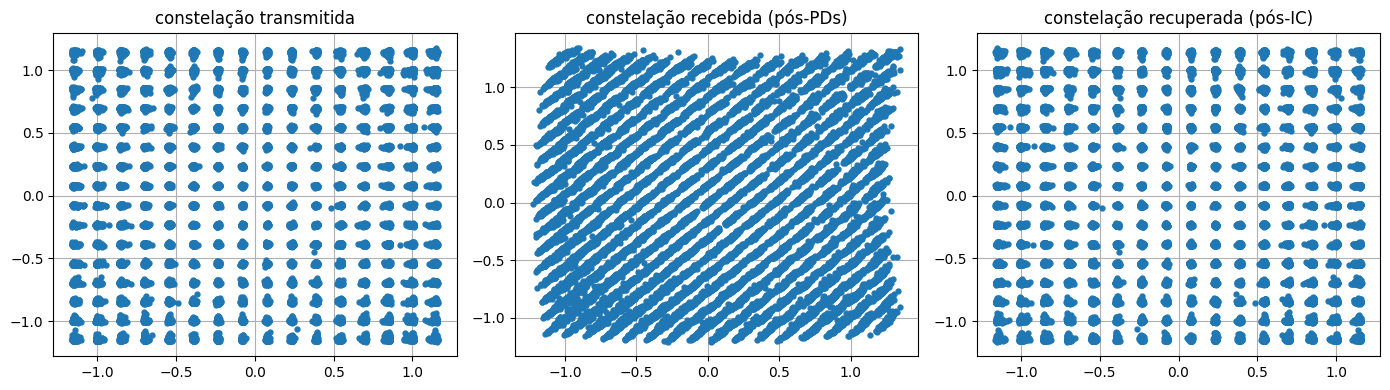

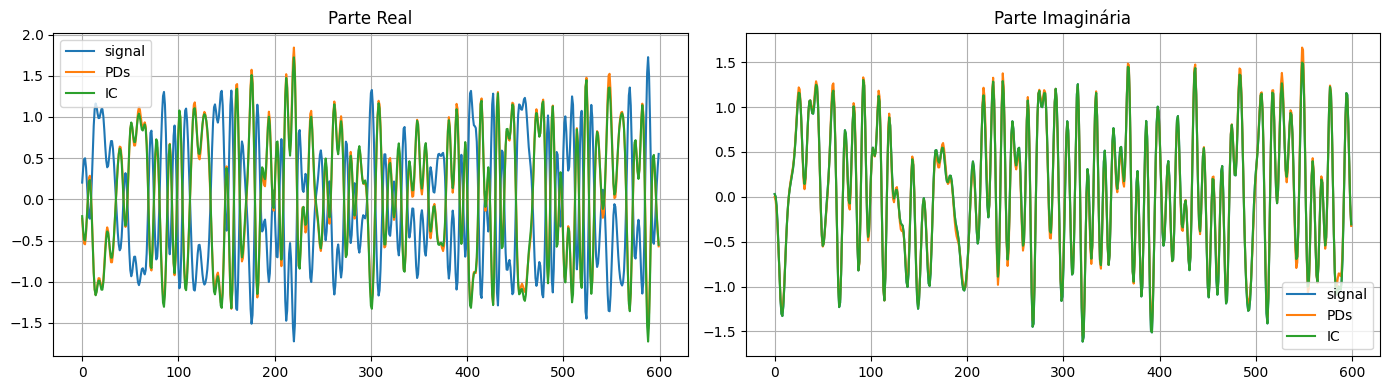

In [11]:
# análise
fig, axs = plt.subplots(1, 3, figsize=(14,4))

axs[0].plot(np.squeeze(sigWDM[2::paramTx.SpS]).real, np.squeeze(sigWDM[2::paramTx.SpS]).imag,'.', markersize=7)
axs[0].set_title('constelação transmitida')
axs[0].grid('True')

axs[1].plot(np.squeeze(sigPD[2::paramTx.SpS]).real, np.squeeze(sigPD[2::paramTx.SpS]).imag,'.', markersize=7)
axs[1].set_title('constelação recebida (pós-PDs)')
axs[1].grid('True')

axs[2].plot(np.squeeze(sigIC[2::paramTx.SpS]).real, np.squeeze(sigIC[2::paramTx.SpS]).imag,'.', markersize=7)
axs[2].set_title('constelação recuperada (pós-IC)')
axs[2].grid('True')

fig.tight_layout()

fig, axs = plt.subplots(1, 2, figsize=(14,4))

axs[0].plot(np.real(sigWDM[0:600]),label = 'signal')
axs[0].plot(np.real(sigPD[0:600]),label = 'PDs')
axs[0].plot(np.real(sigIC[0:600]),label = 'IC')
axs[0].set_title('Parte Real')
axs[0].legend()
axs[0].grid('True')

axs[1].plot(np.imag(sigWDM[0:600]),label = 'signal')
axs[1].plot(np.imag(sigPD[0:600]),label = 'PDs')
axs[1].plot(np.imag(sigIC[0:600]),label = 'IC')
axs[1].set_title('Parte Imaginária')
axs[1].legend()
axs[1].grid('True')

fig.tight_layout()

MSE{sigPD-sigWDM} =  1.9915376517342858
MSE{sigIC-sigWDM} =  1.9915823871557055


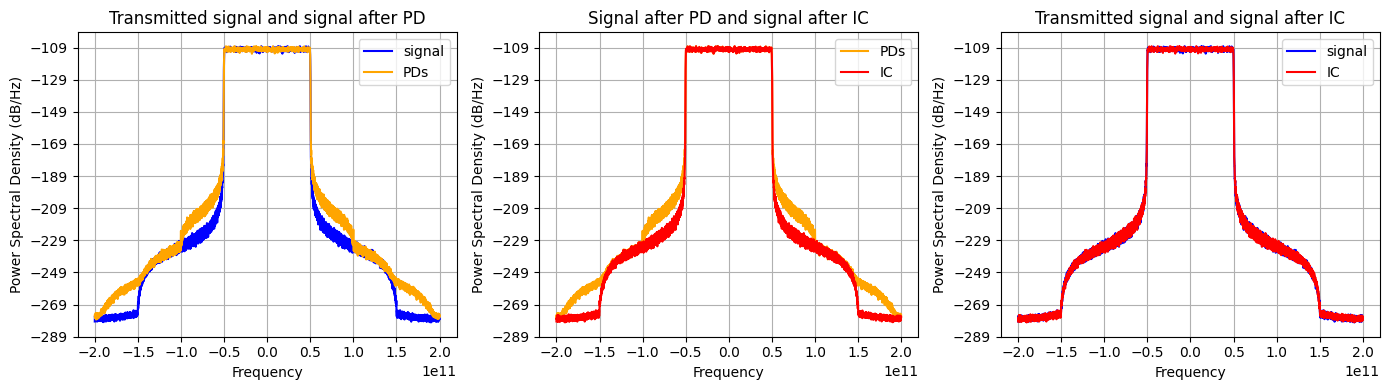

In [12]:
# MSE
print('MSE{sigPD-sigWDM} = ', np.mean(np.abs(sigPD-sigWDM)**2))
print('MSE{sigIC-sigWDM} = ', np.mean(np.abs(sigIC-sigWDM)**2))

# plot psd
fig, axs = plt.subplots(1, 3, figsize=(14,4))

axs[0].psd(sigWDM, Fs=Fs, color='blue', Fc=0, NFFT = 4*1024, sides='twosided',label = 'signal')
axs[0].psd(sigPD, Fs=Fs, color='orange', Fc=0, NFFT = 4*1024, sides='twosided',label = 'PDs')
axs[0].set_title('Transmitted signal and signal after PD')
axs[0].legend()
axs[0].grid('True')

axs[1].psd(sigPD, Fs=Fs, color='orange', Fc=0, NFFT = 4*1024, sides='twosided',label = 'PDs')
axs[1].psd(sigIC, Fs=Fs, color='red', Fc=0, NFFT = 4*1024, sides='twosided',label = 'IC')
axs[1].set_title('Signal after PD and signal after IC')
axs[1].legend()
axs[1].grid('True')

axs[2].psd(sigWDM, Fs=Fs, color='blue', Fc=0, NFFT = 4*1024, sides='twosided',label = 'signal')
axs[2].psd(sigIC, Fs=Fs, color='red', Fc=0, NFFT = 4*1024, sides='twosided',label = 'IC')
axs[2].set_title('Transmitted signal and signal after IC')
axs[2].legend()
axs[2].grid('True')

fig.tight_layout()